In [6]:
import os
import dotenv

from langchain.tools import tool
from langchain.chat_models import init_chat_model

dotenv.load_dotenv(dotenv_path="../.env", override=True)

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_BASE_URL'] = os.getenv('OPENAI_BASE_URL')

print(os.environ['OPENAI_API_KEY'])
print(os.environ['OPENAI_BASE_URL'])

model = init_chat_model(
    model="gpt-4o-mini",
    base_url=os.getenv('OPENAI_BASE_URL'),
    temperature=0
)

# Tool
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add `a` and `b`.
    Args:
    a: First int
    b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> int:
    """
    Divide `a` and `b`.
    Args:
    a: First int
    b: Second int
    """
    return a / b


tools = [add, divide, multiply]
tools_by_name = {tool.name: tool for tool in tools} # 将函数名作为name,方便查找工具
model_with_tools = model.bind_tools(tools)

sk-t2ncP42pm99Vi1XSPSJEVxdXTeS16KzMrvL4UtXhUJPcPqy1
https://api.openai-proxy.org/v1


## 定义状态

In [7]:
from typing_extensions import TypedDict, Annotated
from langchain.messages import AnyMessage
import operator

class MessageState(TypedDict):
    messages: Annotated[AnyMessage, operator.add]
    llm_calls: int

## 定义模型节点

In [8]:
from langchain.messages import SystemMessage

def llm_call(state: dict):
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(content="You're a helpful assistant, you need to help ask their questions")
                ] + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1
    }

## 定义工具节点
调用工具

In [9]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

## 结束

In [10]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessageState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

## 构建编辑代理

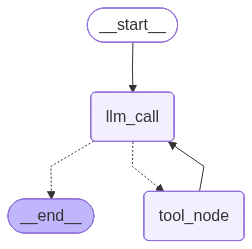

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_OBp3rJWycizP1wfumjqsAzO0)
 Call ID: call_OBp3rJWycizP1wfumjqsAzO0
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [14]:
# Build workflow
agent_builder = StateGraph(MessageState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

## 总结：
核心就是 状态图（StateGraph）。
整个架构分成三层：
| 层级 | 名称 | 说明 |
| ------- | ------- | ------- |
| 基础层 | StateGraph | 定义流程节点和边的结构 |
| 执行层 | Node Func | Node节点方法 |
| 控制层 | State Edge | Edge边、条件边 |

【LLM 推理 ---> 调用工具 ---> 回传结果 ---> 推理 ---> 调用工具】